In [1]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

import matplotlib.pyplot as plt

In [2]:
with pd.HDFStore('E:/data/futures.h5') as store:
        print(store.info())
        factors = store['factors2']

<class 'pandas.io.pytables.HDFStore'>
File path: E:/data/futures.h5
/basic                   frame        (shape->[37,11])                             
/daily_price             [invalid_HDFStore node: 'NoneType' object is not iterable]
/daily_price             frame        (shape->[52303,16])                          
/factors                 frame        (shape->[52291,19])                          
/factors2                frame        (shape->[621,2])                             
/logistic                frame        (shape->[52303,7])                           
/quote                   frame        (shape->[1121,2])                            
/randomforest            frame        (shape->[921,2])                             
/support                                                                           


In [3]:
cu = factors.xs('CU', level=1)
select = ['high_low',
          'high_close',
          'close_low',
          'close_open',
          'gap',
          'vol_change',
          'oi_change',
          'efficiency_10d',
          'volatility',
          'skewness',
          'up_break',
          'down_break',
          'weekly_return',
          'momentum_1m', 
          'label']
cu = cu.loc[:, select] #选择14个特征
cu.dropna(inplace=True)

In [4]:
cu.shape

(1901, 15)

In [5]:
train_size = 1800
x_train = cu.iloc[:train_size, :-1]
y_train = cu.iloc[:train_size, -1]

x_test = cu.iloc[train_size:, :-1]
y_test = cu.iloc[train_size:, -1]

#对输入进行标准化
mean = x_train.mean(0)
std = x_train.std(0)

x_train -= mean
x_train /= std

x_test -= mean
x_test /= std

#将标签设置为one-hot编码
y_train.where(y_train == 1, 0., inplace=True)
y_test.where(y_test == 1, 0., inplace=True)

In [6]:
from keras import models
from keras.layers import Dense, Dropout
from keras.regularizers import l2, l1_l2

Using TensorFlow backend.


In [7]:
#建立一个含有两个隐藏层的前馈神经网络，并使用L2正则化和dropout减小“过拟合”
def build_model():
    model = models.Sequential()
    model.add(Dense(64, activation='elu', kernel_regularizer=l1_l2(0., 0.05), input_shape=(14,)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='elu', kernel_regularizer=l1_l2(0., 0.05)))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='elu', kernel_regularizer=l1_l2(0., 0.05)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
#使用k折交叉验证来调节超参
fold_size = 200
k = train_size // fold_size
epochs_N = 100
batch_S = 512
scores = []
for i in range(k):
    x_val = x_train.iloc[i*fold_size : (i+1)*fold_size, :]
    y_val = y_train[i*fold_size : (i+1)*fold_size]
    
    x_train_ = pd.concat([x_train.iloc[:i*fold_size, :], x_train.iloc[(i+1)*fold_size:, :]])
    y_train_ = pd.concat([y_train[:i*fold_size], y_train[(i+1)*fold_size:]])
    
    model = build_model()
    history = model.fit(x_train_, y_train_, epochs=epochs_N, batch_size=batch_S, 
                        validation_data=(x_val, y_val), verbose=0)
    scores.append(history.history['val_acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


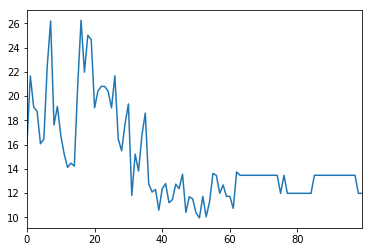

In [9]:
scores_df = pd.DataFrame(scores).T
score_cv = scores_df.mean(1) / scores_df.std(1)
score_cv.plot() #accuracy的变异系数随着迭代次数的变化，图形并不稳定

In [40]:
model = build_model()
model.fit(x_train, y_train, epochs=50, batch_size=batch_S)
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test) #结果同样存在一定的波动

Epoch 1/50
1800/1800 [==============================] - 2s 840us/step - loss: 5.0032 - acc: 0.5089
Epoch 2/50
1800/1800 [==============================] - 0s 19us/step - loss: 4.6704 - acc: 0.5078
Epoch 3/50
1800/1800 [==============================] - 0s 22us/step - loss: 4.4314 - acc: 0.5144
Epoch 4/50
1800/1800 [==============================] - 0s 19us/step - loss: 4.2476 - acc: 0.5022
Epoch 5/50
1800/1800 [==============================] - ETA: 0s - loss: 4.1570 - acc: 0.492 - 0s 19us/step - loss: 4.0872 - acc: 0.5117
Epoch 6/50
1800/1800 [==============================] - 0s 21us/step - loss: 3.9176 - acc: 0.5189
Epoch 7/50
1800/1800 [==============================] - 0s 18us/step - loss: 3.7923 - acc: 0.5194
Epoch 8/50
1800/1800 [==============================] - 0s 19us/step - loss: 3.6333 - acc: 0.5178
Epoch 9/50
1800/1800 [==============================] - 0s 23us/step - loss: 3.5003 - acc: 0.5144
Epoch 10/50
1800/1800 [==============================] - 0s 22us/step - loss: 3

1800/1800 [==============================] - 1s 354us/step


[0.8537505971060859, 0.5077777777777778]

101/101 [==============================] - 0s 69us/step


[0.8530314187012097, 0.5742574258901105]

In [41]:
y_predict = pd.DataFrame(np.where(model.predict(x_test) >= 0.5, 1, 0), 
                         index=y_test.index, columns=['predict'])
records = pd.concat([y_test, y_predict], axis=1)
records['PL_label'] = np.where(records.label == records.predict, 1, -1)
records['PL_label'] = records['PL_label'].shift(1) #将损益标签向未来移动一个交易日
records.dropna(inplace=True)

In [42]:
with pd.HDFStore('E:/data/futures.h5') as store:
        quote = store['quote']
cu_data = quote.xs('CU', level=1)

In [43]:
import sys
sys.path.append(r'C:\Users\54326\Python_Code\self\paper')

import BackTest as bt

In [44]:
nav = bt.get_nav(records['PL_label'], cu_data['pchg'], trans_cost=0.0002)

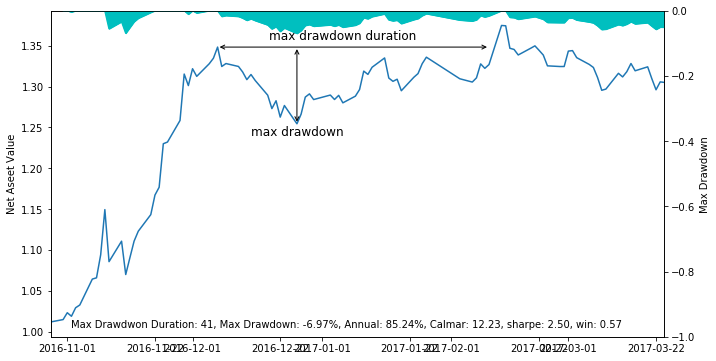

In [45]:
bt.nav_plot(nav, fig_size=(11, 6)) #由于预测结果不稳定，回测结果不是很可靠